# `model.fit_generator` in `keras`

### imports

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, AveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, Adadelta, Adam, SGD
from keras.utils.np_utils import to_categorical 

Using TensorFlow backend.


In [3]:
%cd ..
import mrc

/Users/gw/repos/ece1512_project


### custom function to load in data
- see https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset
'''python
fileList = listOfFiles     

def imageLoader(files, batch_size):

    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = load_data_chunk(files[batch_start:limit])
            Y = someMethodToLoadTargets(files[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size
'''

In [4]:
def parse_file(fname,label):
    #fname = '/Users/gw/Documents/education/2018w/ece1512/project/P11/J85/simulated_particles.mrcs'
    #label = 0
    header = mrc.read_header(fname)
    df = pd.DataFrame({'fname':fname,'idx':range(header['nz']),'class':label})
    return(df)

def parse_files(fname_list,label_list):
    df_list = []
    for fname,label in zip(fname_list,label_list):
        df_list.append(parse_file(fname,label))
    
    return(pd.concat(df_list,axis=0))





In [62]:
fname_list = ['/Users/gw/Documents/education/2018w/ece1512/project/P11/J99/simulated_particles.mrcs',
              '/Users/gw/Documents/education/2018w/ece1512/project/P11/J100/simulated_particles.mrcs']
label_list = [0,1]
df = parse_files(fname_list,label_list)
df = df.sample(df.shape[0])
header = mrc.read_header(fname_list[0])
nx,ny=header['nx'],header['nx']
df = df.iloc[:-1000]
df_val = df.iloc[-1000:]





In [64]:
def read_particle_from_stack(fname,idx,nx=nx,ny=ny):
    particles = mrc.read_imgs(fname,idx=idx,num=1).reshape(1,nx,ny)
    return(particles)

def crop(x,n_crop):
    x = x[:,int(nx/2-n_crop/2):int(nx/2+n_crop/2),int(nx/2-n_crop/2):int(nx/2+n_crop/2),:]
    return(x)

In [65]:
def read_particles(dict_list,nx=ny,ny=ny):
    
    particle_n=0
    particles=np.zeros((len(dict_list),nx,ny))
    for row in dict_list:

        particle = read_particle_from_stack(row['fname'],row['idx'])
        particles[particle_n,:,:] = particle
        particle_n+=1
    return(particles)   

def XY_from_df_batch(df_batch):
    dict_list = df_batch.to_dict('records')
    x_train = read_particles(dict_list)
    #x_train = crop(x_train,128)
    X = x_train[:,:,:,np.newaxis]
    X = crop(X,128) # match 128x128 in Deep Consensus
    Y = to_categorical(df_batch['class'].values, num_classes=2,dtype='int') #https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
    return(X,Y)


def image_loader(df,batch_size):
    
    L = df.shape[0]
    while True: #this line is just to make the generator infinite, keras needs that
        
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end,L)
            X, Y = XY_from_df_batch(df.iloc[batch_start:limit])
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples 
            batch_start += batch_size   
            batch_end += batch_size
#df_batch = df.sample(batch_size, random_state=0)



In [66]:
X,Y = XY_from_df_batch(df.sample(200))
X.shape

(200, 128, 128, 1)

### Check if we can distinguish the resolution by eye

In [40]:
Y.mean(0)

array([0.481, 0.519])

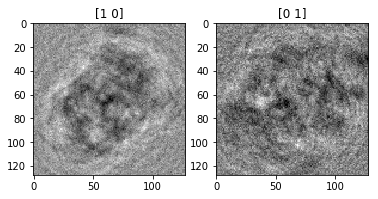

In [67]:
fig = plt.figure()
i,j = 0,2
a = fig.add_subplot(121)
a.set_title('%s' % Y[i])
plt.imshow(X[i,:,:,0],cmap='gray')

a = fig.add_subplot(122)
a.set_title('%s' % Y[j])
plt.imshow(X[j,:,:,0],cmap='gray')

In [11]:
# o_x_train = stack
# o_y_train = np.append(np.zeros(num),np.ones(num))
#np.random.shuffle(o_y_train) # garble labels to check if evaluation accuracy is 50%

In [57]:
# x_train, x_val, y_train, y_val = train_test_split(o_x_train, o_y_train,
#                                                   test_size=0.1,
#                                                   random_state=20) # does random shuffle for us

# y_train_targ = pd.get_dummies(y_train)
# y_val_targ = pd.get_dummies(y_val)

# x_train = x_train[:,:,:,np.newaxis]
# x_val = x_val[:,:,:,np.newaxis]


print('The Training set images have this shape: ' + str(X.shape))
print('The Training set labels have this shape: ' + str(Y.shape))
# print('The Validation set images have this shape: ' + str(x_val.shape))
# print('The Validation set labels have this shape: ' + str(y_val_targ.shape))

The Training set images have this shape: (200, 128, 128, 1)
The Training set labels have this shape: (200, 2)


### set up model
- see the architecture in the Deep Consensus paper (Table 1 in doi:10.1107/S2052252518014392)
- note defaults in [keras documentation](https://keras.io) (eg `strides=1`)
- `padding='same'` to match Deep Consensus Table 1

In [68]:
model = Sequential()
#2
# 1808 = (15*15+1)*8
# plus one for bias
model.add(Conv2D(8, kernel_size=(15,15), activation='relu',input_shape=X.shape[1::], padding='same'))
#3
model.add(Conv2D(8, kernel_size=(15,15),padding='same'))
# see https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras
# not sure if batch normaliztion + relu or relu + batch normaliztion
model.add(Activation('relu'))
model.add(BatchNormalization())

#4
model.add(MaxPooling2D((7,7), strides=2,padding='same'))
#5 
model.add(Conv2D(8, kernel_size=(7,7), activation='relu',padding='same'))
#6
model.add(Conv2D(16, kernel_size=(7,7),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

#7
model.add(MaxPooling2D((5,5), strides=2,padding='same'))
#8 
model.add(Conv2D(32, kernel_size=(3,3), activation='relu',padding='same'))
#9
model.add(Conv2D(32, kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

#10
model.add(MaxPooling2D((3,3), strides=2,padding='same'))
#11
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding='same'))
#12
model.add(Conv2D(64, kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

#13
model.add(AveragePooling2D(pool_size=(4, 4), strides=2,padding='same'))
###
model.add(Flatten())
model.add(Dense(512, activation='relu')) # 2097664 = 512*(8*8*64) ; AveragePooling2D size is 8*8*64=4096
model.add(Dropout(rate=0.5)) # note large dropout rate

n_classes = 2 #np.unique(o_y_train.tolist()).size
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 128, 128, 8)       1808      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 8)       14408     
_________________________________________________________________
activation_13 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 8)         3144      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 16)        6288      
__________

### fit and evaluate model

In [59]:
%%time
model.fit(X, Y, epochs=1, batch_size=20)




Epoch 1/1
200/200 [==============================] - 23s 116ms/step - loss: 0.9110 - categorical_accuracy: 0.5300
CPU times: user 1min 35s, sys: 22.8 s, total: 1min 57s
Wall time: 23.7 s


In [15]:
%%time
model.fit(X, Y, epochs=1, batch_size=100)




Epoch 1/1
1000/1000 [==============================] - 114s 114ms/step - loss: 9.0456e-04 - categorical_accuracy: 1.0000
CPU times: user 7min 55s, sys: 1min 13s, total: 9min 8s
Wall time: 1min 54s


In [60]:
%%time
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

200/200 [==============================] - 8s 39ms/step

categorical_accuracy: 65.50%
CPU times: user 36.5 s, sys: 13.1 s, total: 49.6 s
Wall time: 7.88 s


In [22]:
model.fit_generator(image_loader(df,batch_size=100),steps_per_epoch=10, epochs=1) # steps_per_epoch is number of batches per epoch


Epoch 1/1
10/10 [==============================] - 118s 12s/step - loss: 7.3563e-04 - categorical_accuracy: 1.0000


In [17]:
%%time
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

1000/1000 [==============================] - 42s 42ms/step

categorical_accuracy: 100.00%
CPU times: user 3min 5s, sys: 1min 7s, total: 4min 12s
Wall time: 42.1 s


### training time

| num particles (1000s) | batchsize | time (ETA, min) | platform|
|-|-|-|-|
|1|100|2|gw's macbook pro|
|11|1| 39|"|
|11|2| 29|"|
|11|3| 27|"|
|11|5| 27|"|
|11|10| 23|"|
|11|25| 21|"|
|11|50| 22|"|
|11|100| 30|"|
|11|200| 44|"|
|20|25| 44|"|


In [61]:
df.shape

(19000, 3)

In [ ]:
%%time
batch_size = 25
steps_per_epoch = np.floor(df.shape[0] / batch_size) # 110
model.fit_generator(image_loader(df,batch_size=batch_size),steps_per_epoch=steps_per_epoch, epochs=1) # steps_per_epoch is number of batches per epoch


Epoch 1/1
 90/760 [==>...........................] - ETA: 35:28 - loss: 0.4672 - categorical_accuracy: 0.7600